<a href="https://colab.research.google.com/github/ms-anlaytics/Artificial-Neural-Network-TensorFlow/blob/main/caption_infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OFA**
Start to enjoy image captioning with OFA! 

In [1]:
# clone OFA if there does not exist the repo
%cd /content
!git clone https://github.com/OFA-Sys/OFA.git

/content
Cloning into 'OFA'...
remote: Enumerating objects: 6266, done.
remote: Counting objects: 100% (6266/6266), done.
remote: Compressing objects: 100% (3751/3751), done.
remote: Total 6266 (delta 2514), reused 5242 (delta 2373), pack-reused 0
Receiving objects: 100% (6266/6266), 122.09 MiB | 44.22 MiB/s, done.
Resolving deltas: 100% (2514/2514), done.


## **Download Checkpoint**
We provide a link for our public checkpoint, and you only need to wget it to your workspace. We also provide an alternative below. Choose one as you like!

In [2]:
%cd /content
!mkdir -p /content/OFA/checkpoints/
!wget https://ofa-beijing.oss-cn-beijing.aliyuncs.com/checkpoints/caption_base_best.pt
!mv caption_base_best.pt OFA/checkpoints/caption.pt

/content
--2022-09-21 01:24:33--  https://ofa-beijing.oss-cn-beijing.aliyuncs.com/checkpoints/caption_base_best.pt
Resolving ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)... 59.110.190.134
Connecting to ofa-beijing.oss-cn-beijing.aliyuncs.com (ofa-beijing.oss-cn-beijing.aliyuncs.com)|59.110.190.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2254237467 (2.1G) [application/octet-stream]
Saving to: ‘caption_base_best.pt’

caption_base_best.p 100%[===================>]   2.10G  12.8MB/s    in 2m 57s  

2022-09-21 01:27:31 (12.2 MB/s) - ‘caption_base_best.pt’ saved [2254237467/2254237467]



BTW, if you cannot endure downloading (which might be slow if there are too many people downloading our checkpoint at the same time), we provide an alternative with Google Drive. 

First you need to manually put the checkpoint on your Google Drive by clicking the [URL](https://drive.google.com/file/d/1WBQl0WlzvdctslJyLNgedYpRrWAZC69X/view?usp=sharing) and clicking the bottom on the top right. 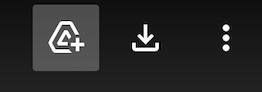

Then you just need to run the codes below without waiting:)

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')
!mkdir -p /content/OFA/checkpoints
!ln -s /content/Drive/MyDrive/caption.pt /content/OFA/checkpoints/caption.pt

## **Install Fairseq**
We advise you to install fairseq by cloning the official repository and running "pip install". 

You should restart the window if you meet the hint of "RESTART RUNTIME". 

In [3]:
# clone Fairseq for installation
%cd /content
!git clone https://github.com/pytorch/fairseq.git -b v0.12.0
%cd /content/fairseq
!pip install --use-feature=in-tree-build ./

/content
Cloning into 'fairseq'...
remote: Enumerating objects: 32718, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 32718 (delta 61), reused 85 (delta 54), pack-reused 32614
Receiving objects: 100% (32718/32718), 22.60 MiB | 31.11 MiB/s, done.
Resolving deltas: 100% (23970/23970), done.
Note: checking out '6795311bfeb9d39fe11a62803184b81acb66509e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/fairseq
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fairseq
  Installing build dependenci

## **Preparation**
Below you just need to import required packages, and check whether to use GPU or FP16. 

In [4]:
%cd /content/OFA
!sed '1d' requirements.txt | xargs -I {} pip install {}

/content/OFA
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=7cae020a0c7526e73527d01bded1a40c904fb38b748081a95abf120a22740b68
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 124 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, 

In [5]:
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image

# Register refcoco task
tasks.register_task('caption', CaptionTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

## **Build Model**
Below you can build your model and load the weights from the given checkpoint, and also build a generator. 

In [6]:
# Load pretrained ckpt & config
overrides={"eval_cider":False, "beam":5, "max_len_b":16, "no_repeat_ngram_size":3, "seed":7}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/caption.pt'),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## **Preprocess**
We demonstrate the required transformation fucntions for preprocessing inputs.

In [7]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose(
    [
        lambda image: image.convert("RGB"),
        transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


## **Run Inference**
Download an image and run the following scripts to generate the caption.

In [8]:
# Download an image from COCO or you can use other images with wget
! wget https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption/resolve/main/donuts.jpg
! mv donuts.jpg ./test.jpg
image = Image.open('test.jpg')

--2022-09-21 01:32:17--  https://huggingface.co/spaces/OFA-Sys/OFA-Image_Caption/resolve/main/donuts.jpg
Resolving huggingface.co (huggingface.co)... 54.173.5.192, 52.5.62.33, 44.195.102.200, ...
Connecting to huggingface.co (huggingface.co)|54.173.5.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364034 (356K) [image/jpeg]
Saving to: ‘donuts.jpg’

donuts.jpg          100%[===================>] 355.50K  --.-KB/s    in 0.1s    

2022-09-21 01:32:17 (2.99 MB/s) - ‘donuts.jpg’ saved [364034/364034]



In [9]:
# Construct input sample & preprocess for GPU if cuda available
import random
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode

sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

In [10]:
# Run eval step for caption
from utils.eval_utils import eval_caption
with torch.no_grad():
    result, scores = eval_caption(task, generator, models, sample)

/content/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


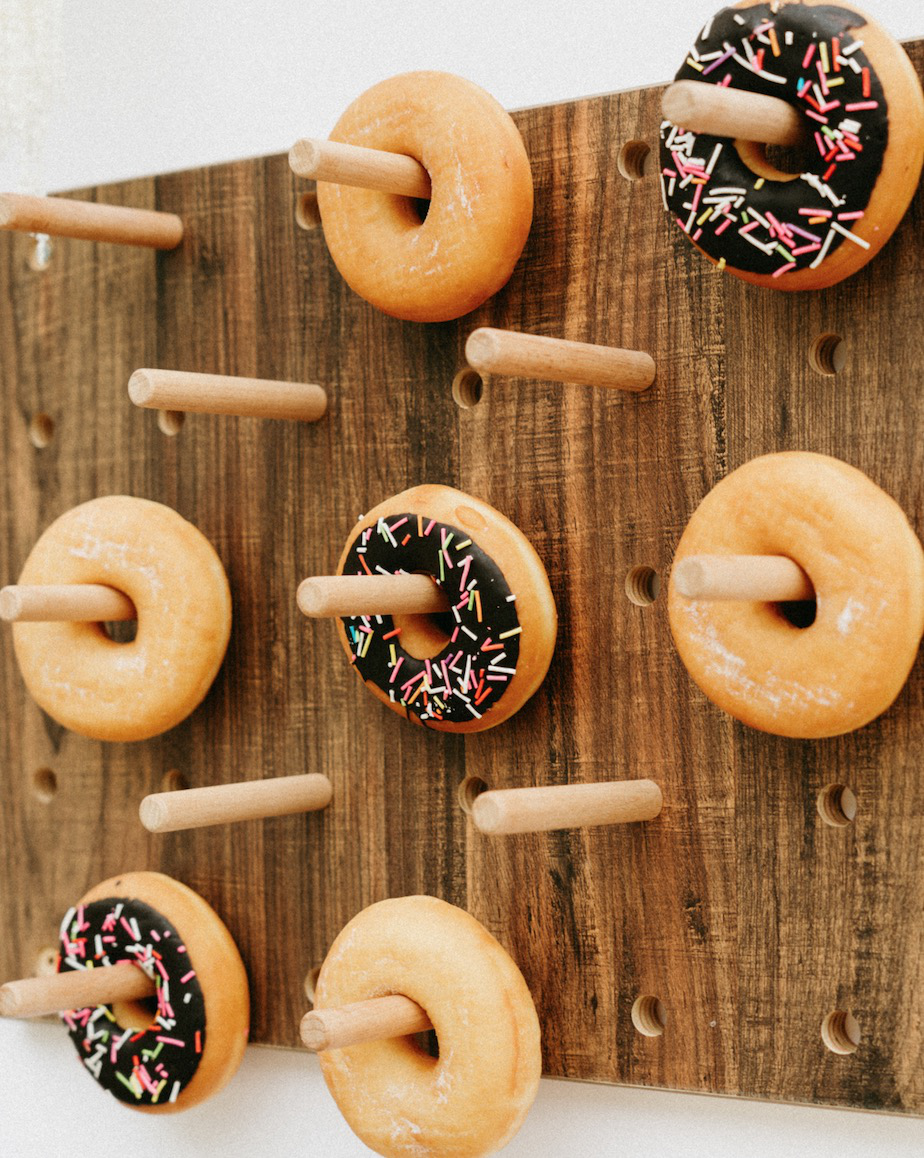

Caption: a group of donuts sitting on a wooden cutting board


In [11]:
display(image)
print('Caption: {}'.format(result[0]['caption']))

In [12]:
!ls

checkpoints	   evaluate.py	  prompt_tuning.md	     test.jpg
checkpoints_cn.md  examples	  README_EncouragingLoss.md  trainer.py
checkpoints.md	   fairseq	  README.md		     train.py
colab.md	   LICENSE	  requirements.txt	     transformers.md
criterions	   models	  run_scripts		     utils
data		   modelscope.md  spaces.md
datasets.md	   ofa_module	  tasks
